In [3]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *

from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

In [95]:
#runlist = np.arange(10)
runlist = [87, 88, 89, 90, 91, 92, 93]
Loaddir = '../Claudio/Reduced_XANES_timescans/'
##############################################3
print ('Will load {} run{}: {} from {}'.format(len(runlist), "" if len(runlist) == 1 else "s", runlist, Loaddir))

Will load 7 runs: [87, 88, 89, 90, 91, 92, 93] from ../Claudio/Reduced_XANES_timescans/


## check data files

In [96]:
datafiles = []
print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '/*{:04d}*/*timescan*'.format(run))
    datafiles.extend(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
print ('{} files found'.format(len(datafiles)))
#datafiles      

[87, 88, 89, 90, 91, 92, 93]
42 files found


# Plotting timescans WITHOUT timetool (same X range)
## (for TT correction go below)

In [97]:
diode_array = ['timescan_DataDiode1_pump', 'timescan_DataDiode1_unpump', 'timescan_Pump_probe_Diode1',
               'timescan_DataDiode2_pump', 'timescan_DataDiode2_unpump', 'timescan_Pump_probe_Diode2']

goodshots_array = ['timescan_goodshots1', 'timescan_goodshots2']

for file in glob.glob(Loaddir+'timescan*.npy'):
    os.remove(file)

for spec in diode_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,spec))
        datafiles.extend(file)
    #datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    spec2save = []
    if len(datafiles)>0:
        for ff in datafiles:
            spec2save.append(np.load(ff, allow_pickle=True))
        print (len(datafiles), spec, np.shape(spec2save))
        np.save(Loaddir+spec+'_all.npy', spec2save)
    else:
        print ('File not found for: {}'.format(spec))
for item in goodshots_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,item))
        datafiles.extend(file)
    #datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    goodshots2save = []
    if len(datafiles)>0:
        for ff in datafiles:
            goodshots2save.append(np.load(ff, allow_pickle=True))
        print (len(datafiles), item, np.shape(goodshots2save))
        np.save(Loaddir+item+'_all.npy', goodshots2save)  
    else:
        print ('File not found for: {}'.format(item))

7 timescan_DataDiode1_pump (7, 41, 3)
7 timescan_DataDiode1_unpump (7, 41, 3)
7 timescan_Pump_probe_Diode1 (7, 41, 3)
File not found for: timescan_DataDiode2_pump
File not found for: timescan_DataDiode2_unpump
File not found for: timescan_Pump_probe_Diode2
7 timescan_goodshots1 (7, 41)
File not found for: timescan_goodshots2


In [98]:
DataDiode1_pump_all = np.load(Loaddir+'/timescan_DataDiode1_pump_all.npy', allow_pickle=True)
DataDiode1_unpump_all = np.load(Loaddir+'/timescan_DataDiode1_unpump_all.npy', allow_pickle=True)
Pump_probe1_all = np.load(Loaddir+'/timescan_Pump_probe_Diode1_all.npy', allow_pickle=True)
goodshots1_all = np.load(Loaddir+'/timescan_goodshots1_all.npy',allow_pickle=True)
try:
    DataDiode2_pump_all = np.load(Loaddir+'/timescan_DataDiode2_pump_all.npy', allow_pickle=True)
    DataDiode2_unpump_all = np.load(Loaddir+'/timescan_DataDiode2_unpump_all.npy', allow_pickle=True)
    Pump_probe2_all = np.load(Loaddir+'/timescan_Pump_probe_Diode2_all.npy', allow_pickle=True)
    goodshots2_all = np.load(Loaddir+'/timescan_goodshots2_all.npy', allow_pickle=True)
except:
    print ('Diode2 files not found')

Diode2 files not found


In [99]:
#### CH1 ####
XAS1_pump        = np.mean(DataDiode1_pump_all[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump_all[:,:,0]-DataDiode1_pump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump_all[:,:,2]-DataDiode1_pump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump_all[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump_all[:,:,0]-DataDiode1_unpump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump_all[:,:,2]-DataDiode1_unpump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe1_all[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
try:
    XAS2_pump        = np.mean(DataDiode2_pump_all[:,:,0], axis=0)
    err2_low_pump    = np.mean((DataDiode2_pump_all[:,:,0]-DataDiode2_pump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
    err2_high_pump   = np.mean((DataDiode2_pump_all[:,:,2]-DataDiode2_pump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

    XAS2_unpump      = np.mean(DataDiode2_unpump_all[:,:,0], axis=0)
    err2_low_unpump  = np.mean((DataDiode2_unpump_all[:,:,0]-DataDiode2_unpump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
    err2_high_unpump = np.mean((DataDiode2_unpump_all[:,:,2]-DataDiode2_unpump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

    XAS2_pump_probe       = np.mean(Pump_probe2_all[:,:,0], axis=0)
    err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
    err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
except:
    print ('Diode2 files not found')

Diode2 files not found


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Diode2 files not found


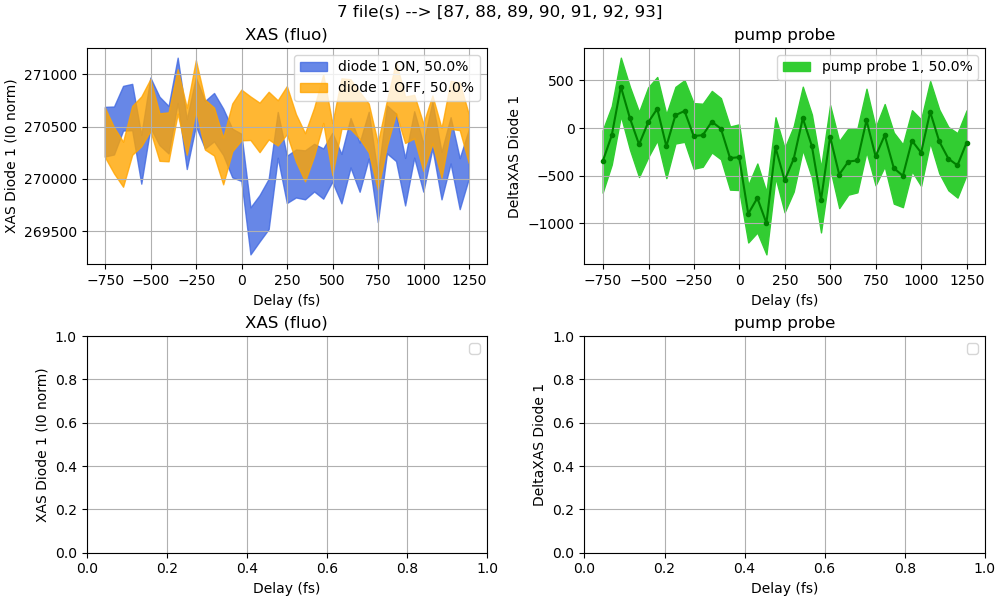

In [100]:
quantile_corr = 0.5

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

ff = glob.glob(Loaddir+'/*{:04d}*/timescan_Delay_fs.npy'.format(runlist[0]))
Delay_fs = np.load(ff[0])

ax1.fill_between(Delay_fs, XAS1_pump - err1_low_pump, XAS1_pump + err1_high_pump , label='diode 1 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
ax1.fill_between(Delay_fs, XAS1_unpump - err1_low_unpump, XAS1_unpump + err1_high_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
ax3.fill_between(Delay_fs, XAS1_pump_probe - err1_low_pump_probe, XAS1_pump_probe + err1_low_pump_probe, label='pump probe 1, {}%'.format(quantile_corr*100),color='limegreen')
ax3.plot(Delay_fs, XAS1_pump_probe, color='green', marker='.')

try:
    ax2.fill_between(Delay_fs, XAS2_pump - err2_low_pump, XAS2_pump + err2_high_pump , label='diode 2 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
    ax2.fill_between(Delay_fs, XAS2_unpump - err2_low_unpump, XAS2_unpump + err2_high_unpump, label='diode 2 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
    ax4.fill_between(Delay_fs, XAS2_pump_probe - err2_low_pump_probe, XAS2_pump_probe + err2_low_pump_probe, label='pump probe 2, {}%'.format(quantile_corr*100),color='limegreen')
    ax4.plot(Delay_fs, XAS2_pump_probe, color='green', marker='.')
except:
    print ('Diode2 files not found')
    
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax3.set_xlabel("Delay (fs)")
ax3.set_ylabel ("DeltaXAS Diode 1")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("XAS Diode 1 (I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

ax4.set_xlabel("Delay (fs)")
ax4.set_ylabel ("DeltaXAS Diode 1")
ax4.set_title('pump probe')
ax4.legend(loc="best")
ax4.grid()

plt.show()

## save the averaged spectra to load them overlaid

In [ ]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

DataDiode1_pump_avg   = np.mean(DataDiode1_pump_all[:,:,:], axis=0)
DataDiode1_unpump_avg = np.mean(DataDiode1_unpump_all[:,:,:], axis=0)
Pump_probe1_avg       = np.mean(Pump_probe1_all[:,:,:], axis=0)
goodshots1_avg        = np.mean(goodshots1_all, axis=0)

save_run_array_timescans(reducedir, run_name, Delay_fs, Delay_fs, DataDiode1_pump_avg, DataDiode1_unpump_avg, Pump_probe1_avg, goodshots1_avg)
print (reducedir+run_name)

# Overlay different timetraces
### load data

In [18]:
#runlist = np.arange(299, 303, 1)
runlist = [43,56]
runlist = [51,55]

runlist = [55,56,57,58,59,60]

runlist = [82,83,84,85,86,87]
runlist = [91,92,89]
runlist = [264]
#runlist = [299, 300]
#runlist = [60, 62, 64, 66]
Loaddir = '../Claudio/Reduced_XANES_timescans/'
##############################################
import glob
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 1 runs: [264] from ../Claudio/Reduced_XANES_timescans/


['../Claudio/Reduced_XANES_timescans/run0264-4TP_H2O_timescan_2474eV/run_array.npy']

# TWO DIODES

No handles with labels found to put in legend.


Diode2 files not found


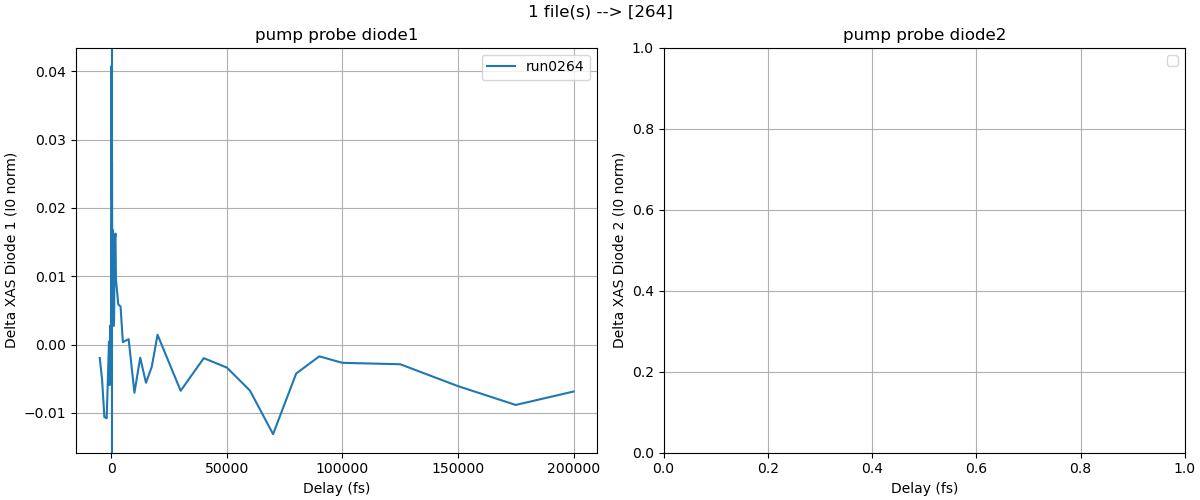

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))
if 'averaged' in Loaddir:
    plt.suptitle('{} file(s) --> {} averaged'.format(len(runlist),str(runlist)))

keys = []

#label = ['RuRh', 'RuRhTEA']

for i,run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        Delay_fs = run_array[key]["Delay_fs"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"][:,0]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        #ax1.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        #ax1.plot(Delay_fs, -XAS1_pump_probe[:,0]/np.min(XAS1_pump_probe[:,0]), label=label[i])
        #ax1.plot(Delay_fs, -XAS1_pump_probe, label=runnumber)
        #ax1.plot(Delay_fs, -XAS1_pump_probe[:,0]/np.min(XAS1_pump_probe[:,0]), label=runnumber)
        
        ax1.plot(Delay_fs, XAS1_pump_probe, label=runnumber)
        #ax1.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label = label[i])
        
        
        try:
            XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"][:,0]
            D2p = run_array[key]["DataDiode2_pump"]
            D2u = run_array[key]["DataDiode2_unpump"]
            gs2 = run_array[key]["goodshots2"]
        
            err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
            err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
            err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
            err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)
        
            err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
            err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
            
            #ax2.axes.errorbar(Delay_fs, XAS2_pump_probe[:,0], err2_low_pump_probe, err2_high_pump_probe, label=runnumber)
            #ax2.plot(Delay_fs, -XAS2_pump_probe[:,0]/np.min(XAS2_pump_probe[:,0]), label=label[i])
            #ax2.plot(Delay_fs, -XAS2_pump_probe[:,0]/np.min(XAS2_pump_probe[:,0]), label=runnumber)
            ax2.plot(Delay_fs, -XAS2_pump_probe, label=runnumber)
            #ax2.axes.errorbar(Delay_fs, XAS2_pump_probe[:,0], err2_low_pump_probe, err2_high_pump_probe, label = label[i])
            
        except:
            print ('Diode2 files not found')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()
ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS Diode 2 (I0 norm)")
ax2.legend()
ax2.grid()

ax1.set_title('pump probe diode1')
ax2.set_title('pump probe diode2')

ax1.axvline(150)

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))
if 'averaged' in Loaddir:
    plt.suptitle('{} file(s) --> {} averaged'.format(len(runlist),str(runlist)))

keys = []

for run in runlist[0::2]:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        Delay_fs = run_array[key]["Delay_fs"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        
        try:
            XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"]
            D2p = run_array[key]["DataDiode2_pump"]
            D2u = run_array[key]["DataDiode2_unpump"]
            gs2 = run_array[key]["goodshots2"]
        
            err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
            err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
            err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
            err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)
        
            err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
            err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
            
            ax2.axes.errorbar(Delay_fs, XAS2_pump_probe[:,0], err2_low_pump_probe, err2_high_pump_probe, label=runnumber)
            
        except:
            print ('Diode2 files not found')

            
for run in runlist[1::2]:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        Delay_fs = run_array[key]["Delay_fs"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax2.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        
        try:
            XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"]
            D2p = run_array[key]["DataDiode2_pump"]
            D2u = run_array[key]["DataDiode2_unpump"]
            gs2 = run_array[key]["goodshots2"]
        
            err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
            err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
            err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
            err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)
        
            err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
            err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
            
            ax2.axes.errorbar(Delay_fs, XAS2_pump_probe[:,0], err2_low_pump_probe, err2_high_pump_probe, label=runnumber)
            
        except:
            print ('Diode2 files not found')
        #ax1.plot(Delay_fs, XAS1_pump_probe[:,0])
        #ax2.plot(Delay_fs, XAS2_pump_probe[:,0])
            
        #plt.plot(run_array[key]["Delay_fs"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()
ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax2.legend()
ax2.grid()

ax1.set_title('pump probe long')
ax2.set_title('pump probe short')

plt.show()

# ONE DIODE

In [29]:
#runlist = [120,121,122,123]
runlist = [145,147,148,150]
#runlist = [299, 300]
#runlist = [60, 62, 64, 66]
runlist=[180,181,182,183]
runlist=[254,255,256,257,258,259]
runlist=[264,265,266,267,268]
Loaddir = '../Claudio/Reduced_XANES_timescans/'
##############################################
import glob
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 5 runs: [264, 265, 266, 267, 268] from ../Claudio/Reduced_XANES_timescans/


['../Claudio/Reduced_XANES_timescans/run0264-4TP_H2O_timescan_2474eV/run_array.npy',
 '../Claudio/Reduced_XANES_timescans/run0265-4TP_H2O_timescan_2466p55eV/run_array.npy',
 '../Claudio/Reduced_XANES_timescans/run0266-4TP_H2O_timescan_2466p35eV/run_array.npy',
 '../Claudio/Reduced_XANES_timescans/run0267-4TP_H2O_timescan_2469p8eV/run_array.npy',
 '../Claudio/Reduced_XANES_timescans/run0268-4TP_H2O_timescan_2472eV/run_array.npy']

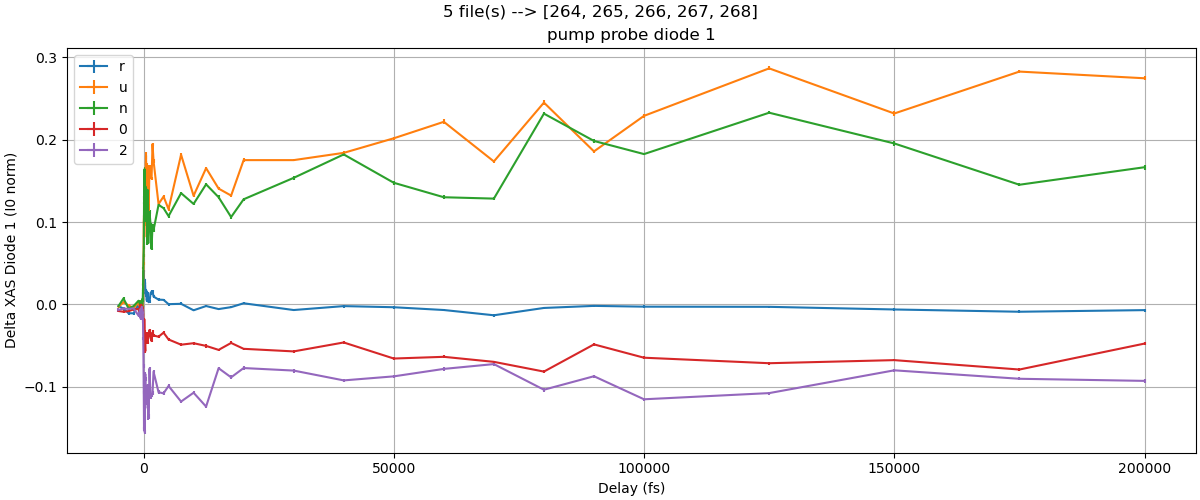

In [30]:
fig, (ax1) = plt.subplots(1, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))
#energylabels = [2465.85,2466.55,2469.25,2472.2] # for H2O time scans
energylabels = [] # for H2O time scans
colornum = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
labels = ['2466.85 V', '2465.85 V']
keys = []

for i, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Delay_fs = run_array[key]["Delay_fs"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
            
        #ax1.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, color=colornum[i], label='{:.2f} eV'.format(energylabels[i]))
        ax1.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber[i])
        
        #plt.plot(run_array[key]["Delay_fs"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()
ax1.set_title('pump probe diode 1')

ax1.legend()
plt.show()

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))
energies = [2466.45,2466.80,2468,2470.1,2472,2473.75] # for H2O time scans
keys = []
labels = 

for run in runlist:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Delay_fs = run_array[key]["Delay_fs"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
            
        ax1.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        
        #plt.plot(run_array[key]["Delay_fs"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()
ax1.set_title('pump probe diode 1')


plt.show()